# Import

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import ipywidgets as widgets
import matplotlib.pyplot as plt
from src.particle import *
from src.tracker import *
from src.widgets import *
import warnings
warnings.filterwarnings('ignore')

# Tracking

In [2]:
path = 'EEMuMu/fourparticles_10.h5'

Output()

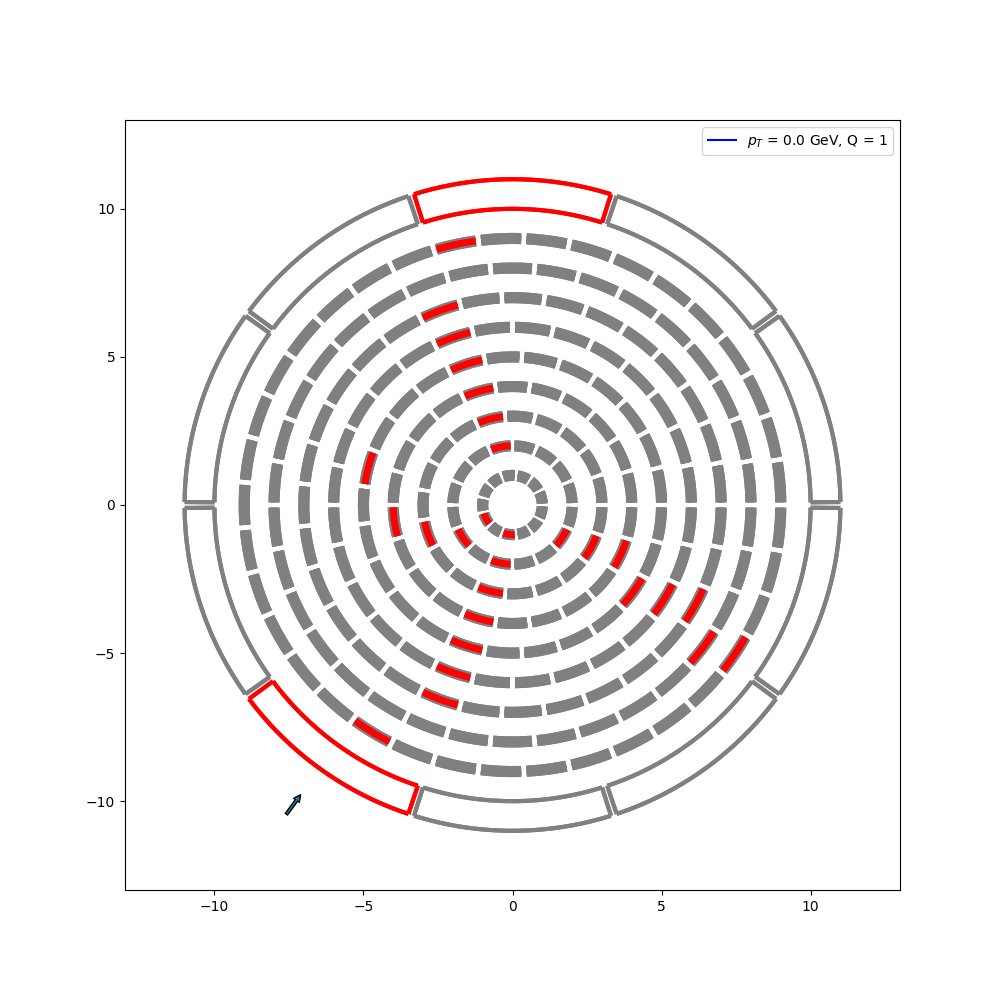

In [15]:
tw = TrackingWidget(path, B = 0.1, layers = 10, n_segments = 10, k = 3, dist = 0.1, noise = False, show_truthbutton = True)
tw.show()

Output()

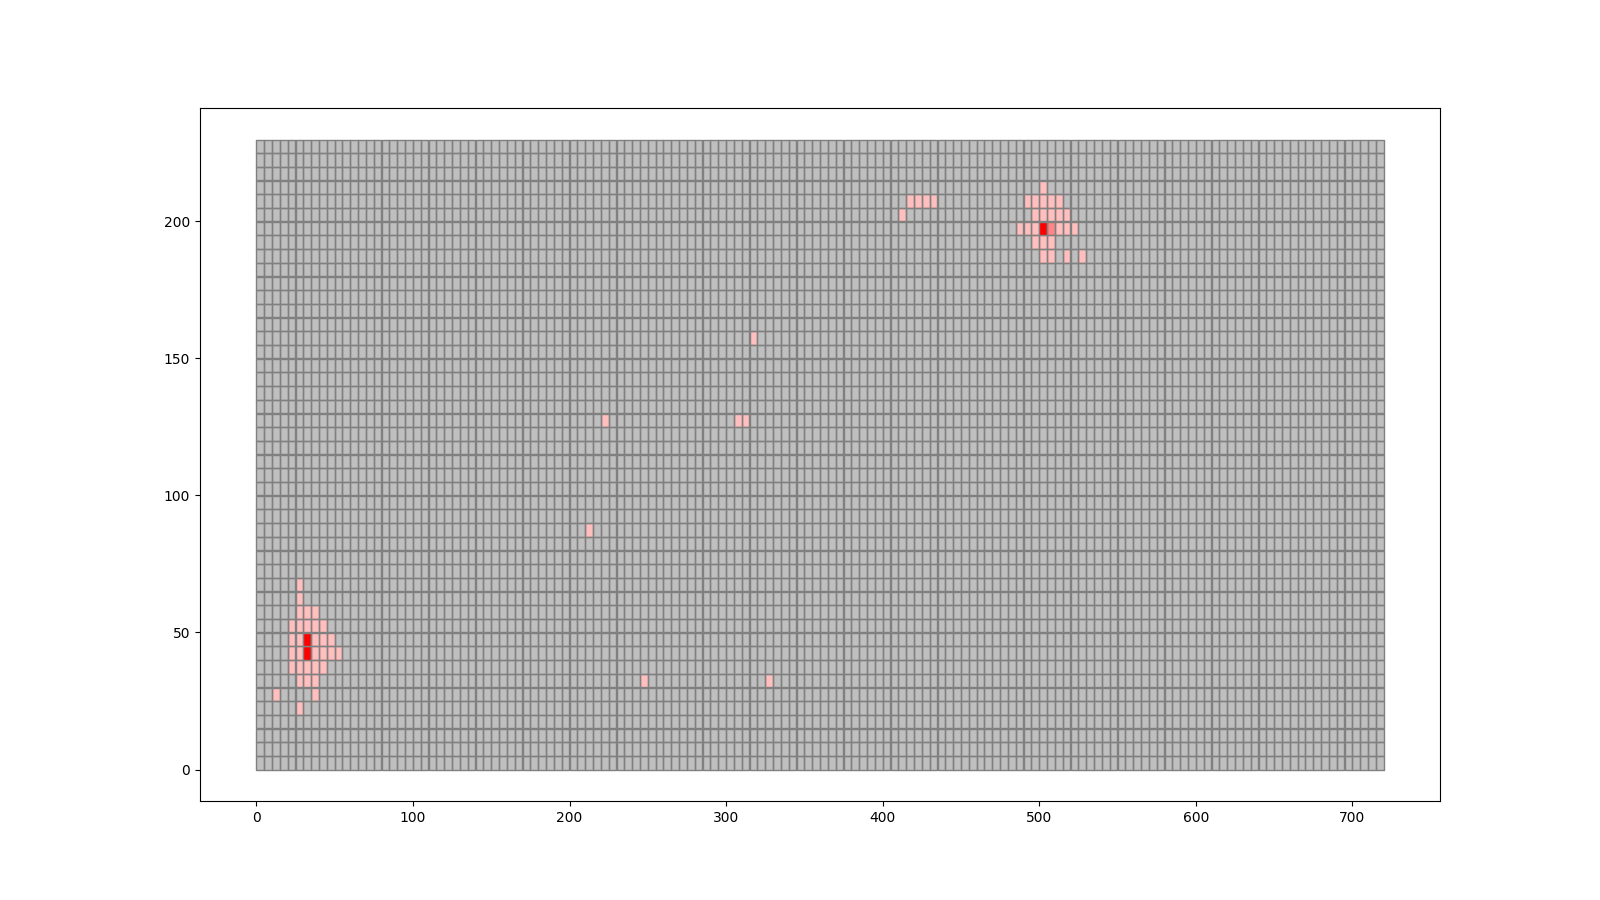

In [13]:
ew = ECLWidget(path, noise_rate = 0.0, )
ew.show()

In [20]:
mw = MatchingWidget(ew, tw)
mw.show()

Output()